In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import autograd.numpy as np
from autograd import grad 
import autograd.numpy.random as npr
from autograd.util import flatten_func, flatten

from scipy.integrate import odeint # for comparision
from scipy.optimize import minimize

## Scipy ODE solver

Note: scipy.integrate.odeint expects f(y, t) but scipy.integrate.ode expects f(t, y) 

- https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html#scipy.integrate.odeint
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html#scipy.integrate.ode

In [2]:
def f(t, y):
    '''
        dy/dt = f(t, y)
        This is f() function on the right
    '''    
    return np.sin(t)

f_yt = lambda y,t: f(t, y) # this is for odeint

In [3]:
t = np.linspace(0, 10, 101).reshape(-1,1)
y = odeint(f_yt, y0=1, t=t.ravel())

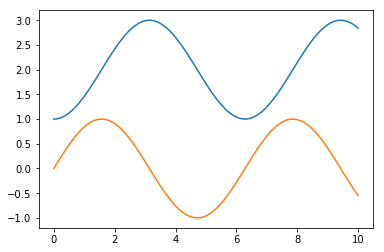

In [4]:
plt.plot(t,y)
plt.plot(t,f(t,None))

## Build neural net

- https://becominghuman.ai/neural-networks-for-solving-differential-equations-fa230ac5e04c
- https://github.com/Rachnog/Neural-Networks-for-Differential-Equations/blob/master/ODE%20example.ipynb

In [5]:
#t = np.linspace(0, 10, 101).reshape(-1,1)
dt = t[1] - t[0]
print(t.shape, dt) 

(101, 1) [ 0.1]


In [6]:
def init_weights(n_in=1, n_hidden=10, n_out=1):
    W1 = npr.randn(n_in, n_hidden)
    b1 = np.zeros(n_hidden)
    W2 = npr.randn(n_hidden, n_out)
    b2 = np.zeros(n_out)
    params = [W1, b1, W2, b2]
    return params

params = init_weights()
print([ p.shape for p in params ])

[(1, 10), (10,), (10, 1), (1,)]


In [7]:
def predict(params, t, act=np.tanh, y0=1):
    W1, b1, W2, b2 = params
    
    a = act(np.dot(t, W1) + b1)
    y = np.dot(a, W2) + b2
    
    phi = y0 + t*y
    
    return phi

In [8]:
predict(params, t).shape # vectorized over t

(101, 1)

In [9]:
predict_dt = grad(predict, argnum=1) # grad w.r.t t

In [10]:
predict_dt(params, t).shape # this is correct

(101, 1)

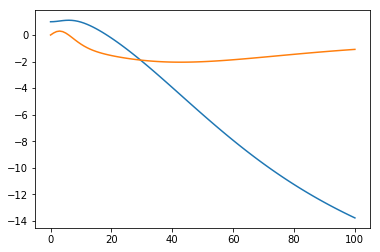

In [11]:
plt.plot(predict(params, t))
plt.plot(predict_dt(params, t))

In [12]:
def loss_func(params, t):
    dydt_pred = predict_dt(params, t)
    dydt_true = f(t,None) # f doesn't contain y for now
    return np.sum( (dydt_pred-dydt_true)**2 )

In [13]:
loss_func(params, t)

320.95297884944802

In [14]:
# loss_grad = grad(loss_func)

In [15]:
flattened_params, unflat_func = flatten(params)

In [16]:
def loss_wrap(flattened_params, t):
    params = unflat_func(flattened_params) # recover
    return loss_func(params, t)

grad_wrap = grad(loss_wrap)

In [17]:
loss_wrap(flattened_params, t)

320.95297884944802

In [18]:
def loss_part(flattened_params):
    '''make partial function. 
    Use this simple method because
    autograd or scipy does not like functool.partial'''
    # warning: global t is used
    return loss_wrap(flattened_params, t)

In [19]:
loss_part_grad = grad(loss_part)

`jac` increases the speed by 50% for normal neural net training, but slows down the traning by 300% in this case? scipy parameter issue?

In [20]:
%%time
optim_params = minimize(loss_part, x0=flattened_params, 
                        jac=False, method="BFGS")
# jac = loss_part_grad is slower

CPU times: user 5.8 s, sys: 66.3 ms, total: 5.87 s
Wall time: 5.96 s


In [21]:
o = optim_params
print(o.fun, o.njev, o.nfev, '\n', o.message)

0.0012039105157018704 295 9747 
 Desired error not necessarily achieved due to precision loss.


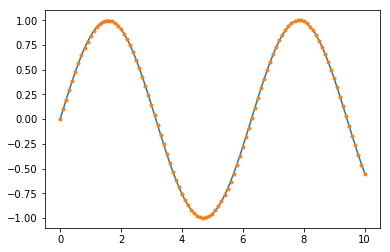

In [22]:
plt.plot(t, f(t,None))
plt.plot(t, predict_dt(unflat_func(o.x), t), '.')

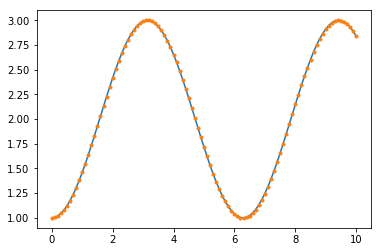

In [23]:
plt.plot(t, y)
plt.plot(t, predict(unflat_func(o.x), t), '.')